# (Test notebook) Are there nans in the ocean domain?

In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from anemoi.datasets import open_dataset 
from anemoi.datasets import MissingDateError
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
year = 2012
file = f'/lustre/storeB/project/fou/hi/foccus/datasets/norkystv3_hindcast_{year}_surface.zarr'

# e.g. dropping ubar and vbar
variable_names = ['Uwind_eastward','Vwind_northward','h','salinity_0','sea_mask','temperature_0','u_eastward_0','v_northward_0','zeta']
ds = open_dataset(file, select=variable_names)

Dataset /lustre/storeB/project/fou/hi/foccus/datasets/norkystv3_hindcast_2012_surface.zarr has missing dates


In [4]:
ds.shape # 9 vars

(8784, 9, 1, 3153556)

In [5]:
# get the index of the missing dates in 2012
ind_missing = np.array(list(ds.missing))
ind_all = np.arange(ds.shape[0])

ind_not_missing = np.setdiff1d(ind_all, ind_missing)
print(type(ind_not_missing[0]))

<class 'numpy.int64'>


In [6]:
# sea mask is constant in time, so just need to use a valid time index
sea_mask = np.bool(ds[int(ind_not_missing[0]),ds.name_to_index['sea_mask'],0,:])

In [7]:
sea_mask[sea_mask].shape

(1822664,)

In [12]:
np.where(~sea_mask)[0]

array([      0,       1,       2, ..., 3150987, 3150988, 3150989])

In [28]:
istep = 100  # step size for time index
for ivar in range(3,4):#ds.shape[1]):
    if ivar == ds.name_to_index['sea_mask']:
            # skip sea_mask var
            continue
    print('-----\nChecking variable:', variable_names[ivar])
    
    for i in range(0, ds.shape[0], istep):
        print(f"i= {i}")

        try:
            print(i, i+istep, ivar)
            ind_time,ind_grid = np.where(np.isnan(ds[i:i+istep,ivar,0,:]))
            print(f"ind_time={ind_time}, ind_grid={ind_grid}") 
        except MissingDateError as e:
            print(f"MissingDateError:",e)
            i_not_missing = np.intersect1d(ind_not_missing, np.arange(i, i+istep))
            print(f"i_not_missing={i_not_missing}")
            if i_not_missing.size != 0:
                ind_time,ind_grid = np.where(np.isnan(ds[i_not_missing[0]:i_not_missing[-1]+1,ivar,0,:]))
                ind_time += i_not_missing[0]  # adjust index to the current step
                #print(f"ind_time={ind_time}, ind_grid={ind_grid}")
            else:
                ind_time = np.array([])  

        if ivar not in ['Uwind_eastward','Vwind_northward','u_eastward_0','v_northward_0']:
            # The above variables has values over land. 
            # For those that dont, we will only write to file when nans found in the sea
            intersect_nan_sea = np.intersect1d(ind_grid, np.where(sea_mask)[0], return_indices=True)[0]
            ind_grid = ind_grid[intersect_nan_sea]
            ind_time = ind_time[intersect_nan_sea]
            # this ofthen returns empty arrays
        if ind_time.size > 0 and ind_grid.size > 0:
            for n in range(len(ind_time)):
                it=int(ind_time[n])
                ig=int(ind_grid[n])
                #f.write(f"ds[ {i+it}, {ivar}, 0, {ig} ] = {ds[i+it,ivar,0,ig]}\n")
                print(f"ds[ {i+it}, {ivar}, 0, {ig} ] = {ds[i+it,ivar,0,ig]}\n")


-----
Checking variable: salinity_0
i= 0
0 100 3
MissingDateError: Date 2012-01-01T00:00:00 is missing (index=0)
i_not_missing=[96 97 98 99]
i= 100
100 200 3


MemoryError: Unable to allocate 10.6 GiB for an array with shape (9, 100, 1, 3153556) and data type float32

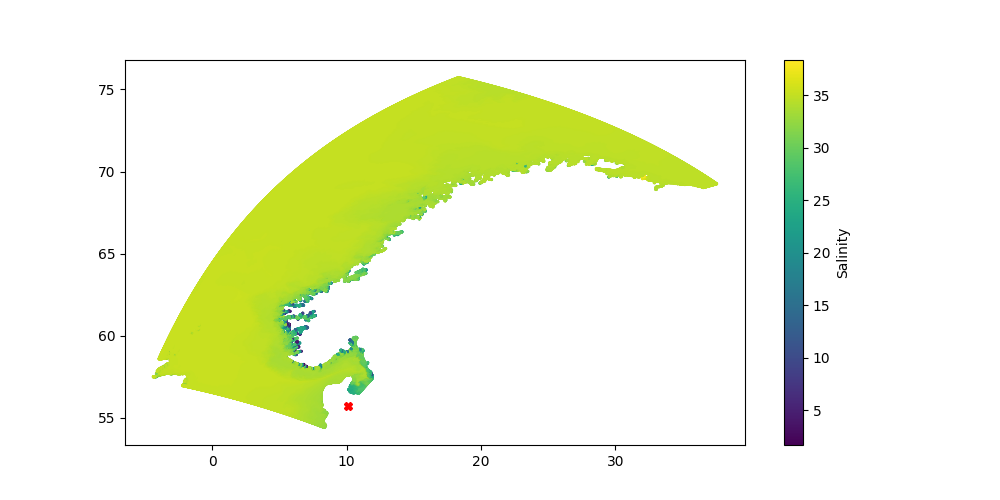

In [20]:
salinity = ds[int(ind_not_missing[0]),ds.name_to_index['salinity_0'],0,:]

plt.figure(figsize=(10, 5))
plt.scatter(ds.longitudes,ds.latitudes ,c=salinity, s=1, label='Salinity')

plt.plot(ds.longitudes[238],ds.latitudes[238],"X", c='r', label='Salinity Point (96,3,0,238)')
#ds[96,3,0,238]

plt.colorbar(label='Salinity')

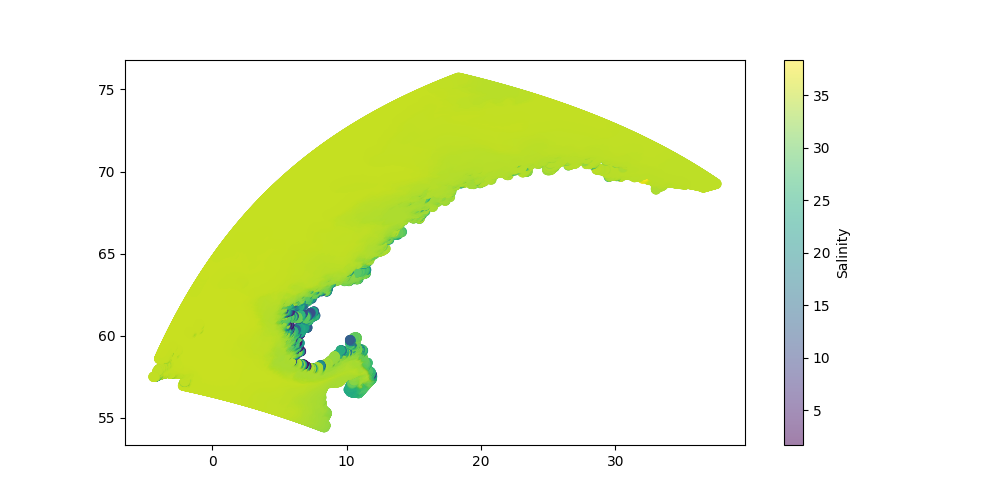

In [ ]:
# mask out sea for salinity
plt.figure(figsize=(10, 5))
plt.scatter(ds.longitudes[sea_mask], ds.latitudes[sea_mask], c=salinity[sea_mask], s=1, label='Salinity (Sea Masked)', alpha=0.5)
plt.colorbar(label='Salinity')

In [38]:
np.isnan(salinity[~sea_mask][0])

np.True_